In [2]:
%matplotlib inline
import math
import time
import numpy as np
import torch
import d2l

# Normal distribution: $p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right).$

In [3]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

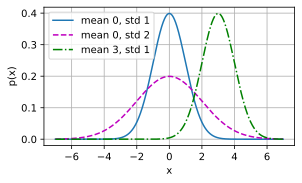

In [4]:
# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

One way to motivate linear regression with squared loss
is to assume that observations arise from noisy measurements,
where the noise $\epsilon$ follows the normal distribution 
$\mathcal{N}(0, \sigma^2)$:

$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon \textrm{ where } \epsilon \sim \mathcal{N}(0, \sigma^2).$$

Thus, we can now write out the *likelihood*
of seeing a particular $y$ for a given $\mathbf{x}$ via

$$P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).$$

As such, the likelihood factorizes.
According to *the principle of maximum likelihood*,
the best values of parameters $\mathbf{w}$ and $b$ are those
that maximize the *likelihood* of the entire dataset:

$$P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)} \mid \mathbf{x}^{(i)}).$$

The equality follows since all pairs $(\mathbf{x}^{(i)}, y^{(i)})$
were drawn independently of each other.
Estimators chosen according to the principle of maximum likelihood
are called *maximum likelihood estimators*.
While, maximizing the product of many exponential functions,
might look difficult,
we can simplify things significantly, without changing the objective,
by maximizing the logarithm of the likelihood instead.
For historical reasons, optimizations are more often expressed
as minimization rather than maximization.
So, without changing anything,
we can *minimize* the *negative log-likelihood*,
which we can express as follows:

$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

# Poisson distribution: [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) 
captures distributions over counts. It is given by $p(k \mid \lambda) = \lambda^k e^{-\lambda}/k!$. 

Here $\lambda$ is the rate function and $k$ is the number of events you see. 

*likelihood* of the entire dataset:

$$P(\mathbf k \mid \mathbf \lambda) = \prod_{i=1}^{n} p(k^{(i)} \mid \mathbf{\lambda}^{(i)}).$$

negative Poisson log-likelihood: $$-\log P(\mathbf k \mid \mathbf \lambda) = \sum_i (1^T \lambda_i - k_i^T \log(\lambda_i + \epsilon)).$$

Depending on the noise in your data, choose the loss function accordingly!

In [5]:
class SyntheticRegressionData(d2l.DataModule):  #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

In [6]:
w_groundtruth = torch.tensor([2, -3.4])
b_groundtruth = 4.2
data = SyntheticRegressionData(w=w_groundtruth, b=b_groundtruth)

In [8]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tensor([1.0507, 0.6014]) 
label: tensor([4.2560])


In [11]:
data.X.shape, data.y.shape

(torch.Size([2000, 2]), torch.Size([2000, 1]))

In [12]:
@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)

@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [15]:
data.batch_size=32
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [19]:
def model(X, w, b):
    return torch.matmul(X, w) + b

In [16]:
class LinearRegressionScratch(torch.nn.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, sigma=0.01):
        super().__init__()                
        self.w = torch.nn.Parameter(torch.normal(0, sigma, (num_inputs, 1), requires_grad=True))
        self.b = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
    def forward(self, X):
        return torch.matmul(X, self.w) + self.b

In [17]:
def loss(y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

In [18]:
#Training definitions
def train_loop(dataloader, model, loss_fn, optimizer):
  avg_loss = 0
  size = len(dataloader.dataset)
  for batch_i, (X, y) in enumerate(dataloader):
    # print(batch_i)
    #Compute the prediction (i.e. forward pass)
    pred = model(X)
    
    #Compute the loss
    loss = loss_fn(pred,y)  

    #Backpropagation
    #First, reset the gradients of the model parameters
    optimizer.zero_grad()
    #Back prop the prediction loss
    loss.backward()
    #Adjust the parameters using the gradients collected
    optimizer.step()

    #Log the loss and dice score
    avg_loss += loss.item() #Undo the normalization by mini-batch size
  return avg_loss/size


In [19]:
from torch.optim import SGD 
model = LinearRegressionScratch(2)
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
data.batch_size = 2
optim = SGD(model.parameters(), lr=1e-2)

In [25]:
for i in range(5):
    train_loop(dataloader=data.get_dataloader(train=True), model=model, loss_fn=loss, optimizer=optim)

In [26]:
(model.w, w_groundtruth), (model.b, b_groundtruth)

((Parameter containing:
  tensor([[ 1.9998],
          [-3.4004]], requires_grad=True),
  tensor([ 2.0000, -3.4000])),
 (Parameter containing:
  tensor([4.2000], requires_grad=True),
  4.2))

In [27]:
def test_loop(dataloader, model, loss_fn):
  avg_loss = 0
  size = len(dataloader.dataset)
  model.eval()
  with torch.no_grad():
    for batch_i, (X,y) in enumerate(dataloader):
      #Compute the prediction (i.e. forward pass)
      pred = model(X)
      #Compute the loss
      loss = loss_fn(pred,y) 
      #Log the loss and dice score
      avg_loss += loss.item() 
  return avg_loss/size

In [28]:
test_loop(dataloader=data.get_dataloader(train=False), model=model, loss_fn=loss)


2.446752305921862e-05

In [30]:
data.X.shape

torch.Size([2000, 2])

In [48]:
x = np.linspace(-4,4,50)
y = np.linspace(-4,4,50)
X,Y = np.meshgrid(x,y)

test_input = np.zeros((50*50,2))
test_input[:,0] = X.ravel()
test_input[:,1] = Y.ravel()
test_input.shape

test_out = model(torch.tensor(test_input).float())
test_out.shape

xy = test_input 
z = test_out.detach().numpy()


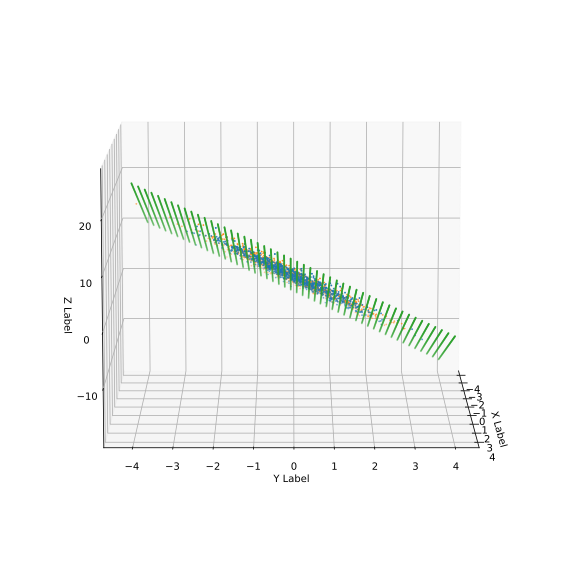

In [52]:
import matplotlib.pyplot as plt
import numpy as np

train = data.X[:1000]
test = data.X[1000:]

out_train = data.y[:1000]
out_test = data.y[1000:]

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')

n = 100



ax.scatter(train[:, 0], train[:, 1], out_train, marker='o', s=1)
ax.scatter(test[:, 0], test[:, 1], out_test, marker='x', s=1)
ax.scatter(xy[:, 0], xy[:, 1], z, marker='*', s=1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(elev=10, azim=0)
plt.show()

In [32]:
train.shape

torch.Size([1000, 2])